In [1]:
library(tidyverse)
library(lubridate)
library(corrplot)

set.seed(1992)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

corrplot 0.84 loaded


In [2]:
## some environmental stuff I can keep returning to

get_corrPlot <- function(x, n_modules=6){
    xcor <- cor(x)
    res1 <- cor.mtest(xcor, conf.level = 0.95)
    corrplot(
        xcor, order = 'hclust', addrect = n_modules, tl.col='black', 
        #col=colorRampPalette(c("magenta4",'white',"royalblue4"))(200)
    )
}

build_dailyComposite <- function(x, dates=days_of_sampling, n_days, n_modules=6){
    new_meta <- list()

    for (d in dates){
        idx <- which(weather_df$Date == as.Date(d)) - 1 # -1 excludes day of sampling
        meta <- c()
        sub <- weather_df[((idx - n_days):idx), ]
        meta <- c(meta, 
                  mean(sub$maxT), mean(sub$minT), mean(sub$avgT),
                  mean(sub$maxWind), sum(sub$precip),mean(sub$maxP), 
                  mean(sub$minP), mean(sub$avgDP), mean(sub$maxDP), mean(sub$minDP),  
                  sum(sub$totalRad), mean(sub$dT), 
                  mean(sub$dP), mean(sub$dDP), mean(sub$evap))
        new_meta[[d]] <- meta
    }

    new_meta <- as.data.frame(t(as.data.frame(new_meta)))
    dim(new_meta)
    colnames(new_meta) <- c('avgmaxT', 'avgminT', 'avgavgT', 'avgmaxW', 'sumPrecip', 
                            'avgmaxP', 'avgminP', 'avgavgDP','avmaxDP','avgminDP' ,
                            'sumRad', 'avgdT', 'avgdP', 'avgdDP', 'avgEvap')
    new_meta$Date <- as.Date(dates)
    new_meta %>%
      select(-Date) %>%
      get_corrPlot(n_modules=n_modules)
}




days_of_sampling <- c('2017-05-22', '2017-07-30', '2017-09-25', 
                      '2018-05-30', '2018-08-01', '2018-09-17', 
                      '2019-05-23', '2019-08-05', '2019-09-17')

days_before_sampling <- c('2017-05-21', '2017-07-29', '2017-09-24', 
                          '2018-05-29', '2018-07-31', '2018-09-16', 
                          '2019-05-22', '2019-08-04', '2019-09-16')

## Daily Measures

In [3]:
weather_df <- read.csv('../../../2017_2020_weather_station_metric.csv')
colnames(weather_df) <- c('MONTH', 'DAY', 'YEAR', 'maxT', 'minT', 'avgT', 
                          'maxWind', 'precip', 'maxP', 'minP', 'avgDP', 
                          'maxDP', 'minDP', 'evap', 'totalRad')
weather_df$Date <- paste(weather_df$YEAR, weather_df$MONTH, weather_df$DAY, sep='-')
weather_df$Date <- as.Date(weather_df$Date)
head(weather_df)

MONTH,DAY,YEAR,maxT,minT,avgT,maxWind,precip,maxP,minP,avgDP,maxDP,minDP,evap,totalRad,Date
1,1,2017,11.6,-5.4,3.2,8.9,0.00,1016,1012,-1.2,5.6,-7.5,1.131,7.84,2017-01-01
1,2,2017,10.9,6.1,8.3,7.2,1.27,1013,1008,7.7,10.0,5.6,0.350,3.06,2017-01-02
1,3,2017,10.0,-6.4,2.3,9.2,0.00,1024,1010,0.7,10.0,-10.4,0.253,1.02,2017-01-03
1,4,2017,-1.1,-10.5,-5.8,8.7,0.00,1026,1016,-13.2,-10.2,-15.7,0.870,10.74,2017-01-04
1,5,2017,-3.8,-12.2,-8.7,7.4,0.00,1024,1016,-12.3,-8.2,-17.9,0.316,3.34,2017-01-05
1,6,2017,-9.8,-15.6,-12.4,7.2,0.00,1032,1023,-18.0,-16.4,-20.1,0.424,6.12,2017-01-06


In [4]:
#construct some summary stats

#difference in pressure
weather_df$dP <- weather_df$maxP - weather_df$minP

#difference in temp
weather_df$dT <- weather_df$maxT - weather_df$minT

#difference in dew point
weather_df$dDP <- weather_df$maxDP - weather_df$minDP

### First I want to see the correlation structure of the data themselves

Here I will just make rough correlation plots for the measurements on the full dataset, a smaller window in which all of our samples were taken, the day before we sampled, and the day that we samples. 

In [5]:
# correlations from the full daily dataset
pdf('weather_figures/1719_daily_corrPlot_full.pdf', height=8, width=8)
weather_df %>% 
  select(-MONTH, -DAY, -YEAR, -Date) %>%
  get_corrPlot(n_modules=8)
dev.off()

pdf 
  2

In [6]:
# see if measurements within the window change at all
weather_df$MonthDay <- format(weather_df$Date, '%m-%d')
weather_df$MonthDay <- as.Date(paste(rep("1904", length(weather_df$Date)), 
                                     month(weather_df$Date), 
                                     day(weather_df$Date), 
                                     sep='-'))

pdf('weather_figures/1719_daily_corrPlot_window.pdf', height=8, width=8)
weather_df %>%
  filter(MonthDay >= '1904-5-01' & MonthDay < '1904-10-01') %>%
  select(-Date, -MONTH, -YEAR, -DAY, -MonthDay) %>%
  get_corrPlot(n_modules=9)
dev.off()

pdf 
  2

In [7]:
# day before measurements
pdf('weather_figures/1719_daily_corrPlot_dayBefore.pdf', height=8, width=8)

weather_df %>%
  filter(Date %in% as.Date(days_before_sampling)) %>% 
  select(-Date, -MONTH, -YEAR, -DAY, -MonthDay) %>%
  get_corrPlot(n_modules=7)
dev.off()

pdf 
  2

In [8]:
# see if day of measurements change considerably
pdf('weather_figures/1719_daily_corrPlot_dayOf.pdf', height=8, width=8)

weather_df %>%
  filter(Date %in% as.Date(days_of_sampling)) %>% 
  select(-Date, -MONTH, -YEAR, -DAY, -MonthDay) %>%
  get_corrPlot(n_modules=6)

dev.off()

pdf 
  2

### Second, I want to see if building composite summaries changes the correlation structure

Like in the ionomics data, I will look at 7- and 3- day summaries. Both of these are likely too large already, but will caputure general trens. But I am excluding the 14-day summary. 

In [9]:
#7 day
pdf('weather_figures/1719_daily_corrPlot_7Day.pdf', height=8, width=8)

build_dailyComposite(weather_df, dates=days_of_sampling, n_days=7, n_modules=6)

dev.off()

pdf 
  2

In [10]:
# 3 day
pdf('weather_figures/1719_daily_corrPlot_3Day.pdf', height=8, width=8)

build_dailyComposite(weather_df, dates=days_of_sampling, n_days=3, n_modules=4)

dev.off()

pdf 
  2

## Hourly Summary

In [11]:
weather_df_hourly <- read.csv('../../../2017_2020_weather_station_metric_hourly.csv')
colnames(weather_df_hourly) <- c('MONTH', 'DAY', 'YEAR', 'HOUR', 'avgT', 'precip', 'windSpeed', 
                          'windDirection', 'relHumidity', 'avgSolarRad', 'totalSolarRad', 'totalSolarRadDensity', 
                          'pressure', 'evap', 'calcClearSkyRad')
weather_df_hourly$Date <- paste(weather_df_hourly$YEAR, weather_df_hourly$MONTH, weather_df_hourly$DAY, sep='-')
weather_df_hourly$Date <- as.Date(weather_df_hourly$Date)
head(weather_df_hourly)

MONTH,DAY,YEAR,HOUR,avgT,precip,windSpeed,windDirection,relHumidity,avgSolarRad,totalSolarRad,totalSolarRadDensity,pressure,evap,calcClearSkyRad,Date
1,1,2017,100,0.2,0,1,51,62,0,0.10,1015,-6.2,-0.005,0,2017-01-01
1,1,2017,200,-0.6,0,1,86,65,0,0.10,1015,-6.3,-0.002,0,2017-01-01
1,1,2017,300,-2.3,0,1,78,74,0,0.11,1015,-6.4,-0.003,0,2017-01-01
1,1,2017,400,-2.4,0,1,106,74,0,0.03,1015,-6.4,-0.007,0,2017-01-01
1,1,2017,500,-3.3,0,1,78,79,0,0.02,1014,-6.5,-0.009,0,2017-01-01
1,1,2017,600,-4.2,0,1,99,83,0,0.05,1014,-6.6,-0.006,0,2017-01-01


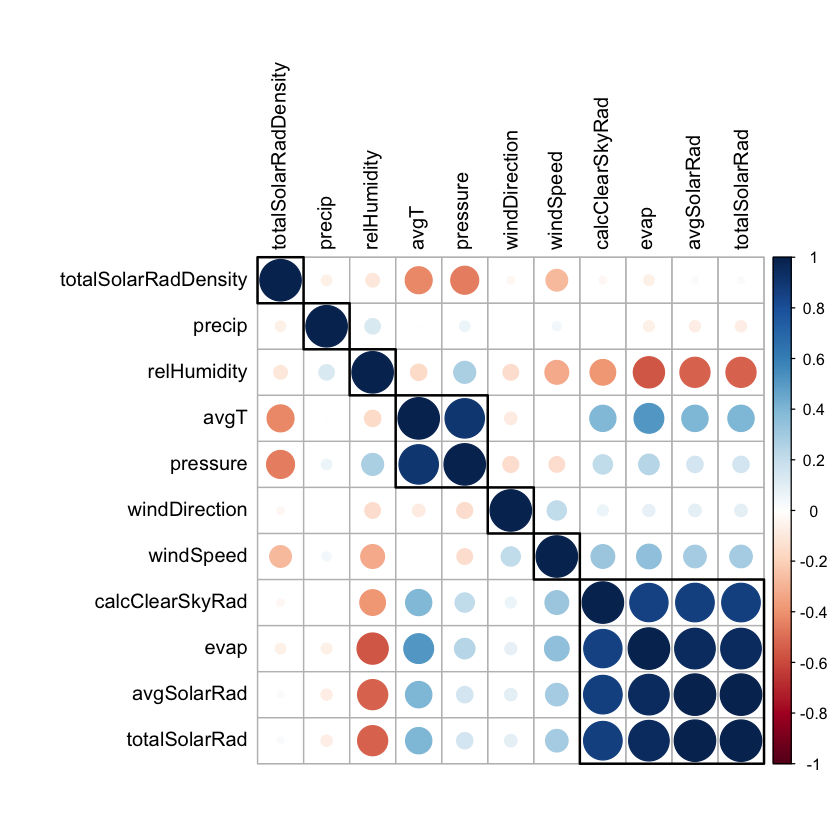

In [12]:
weather_df_hourly %>% 
  select(-MONTH, -DAY, -YEAR, -HOUR, -Date) %>%
  get_corrPlot(n_module=7)

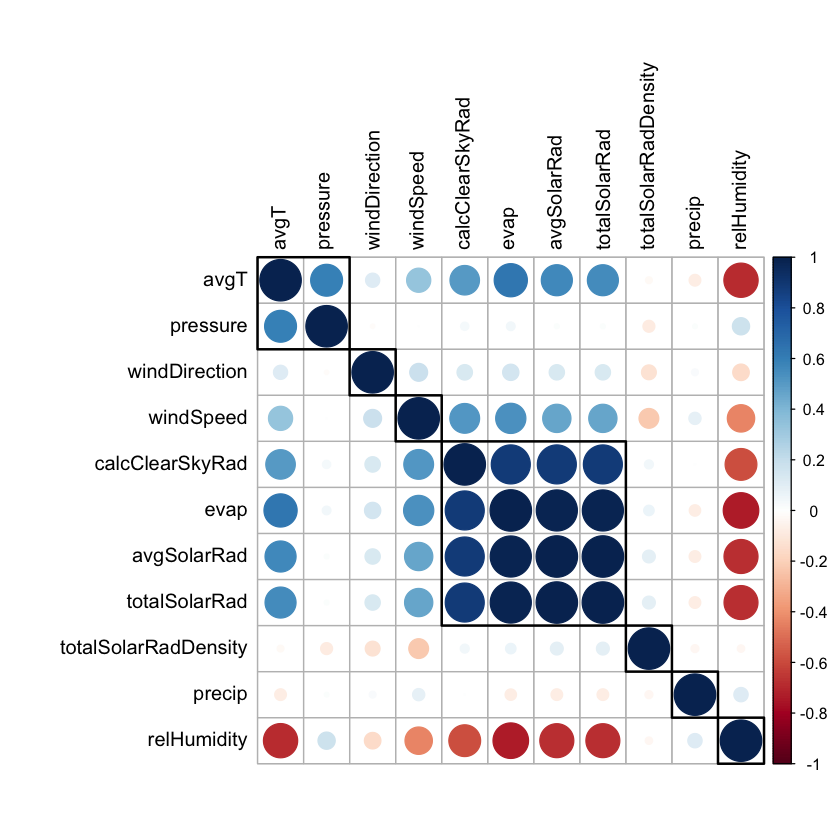

In [13]:
weather_df_hourly$MonthDay <- format(weather_df_hourly$Date, '%m-%d')
weather_df_hourly$MonthDay <- as.Date(paste(rep("1904", length(weather_df_hourly$Date)), 
                                     month(weather_df_hourly$Date), 
                                     day(weather_df_hourly$Date), 
                                     sep='-'))

weather_df_hourly %>% 
  filter(MonthDay >= '1904-5-01' & MonthDay < '1904-10-01') %>%
  select(-MONTH, -DAY, -YEAR, -HOUR, -Date, -MonthDay) %>%
  get_corrPlot(n_module=7)

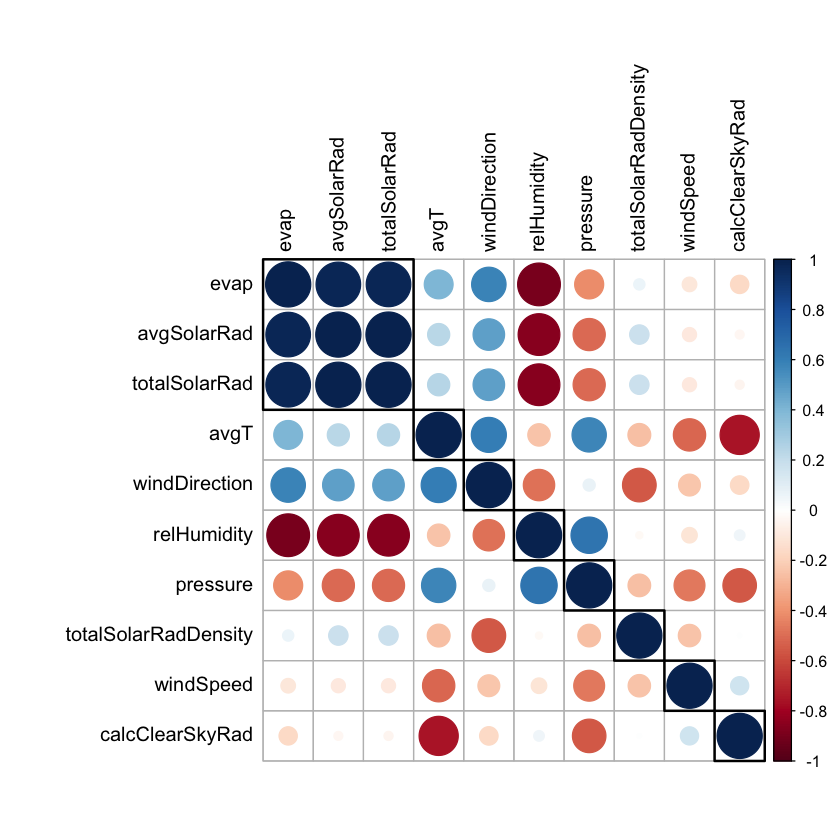

In [14]:
## see what time-of measurements look like
weather_df_hourly %>%
  filter(Date %in% as.Date(days_of_sampling)) %>% 
  filter(HOUR == 1000) %>%
  select(-Date, -MONTH, -YEAR, -DAY, -HOUR, -MonthDay, -precip) %>%
  get_corrPlot(n_modules=8)

### Matthew's suggestion for two 24 hour windows

Here I will build two 24-hour windows based on 24 hours before sampling and 24 hours before sunrise on the day of sampling (something something clock entrainment). 

In [15]:
weather_df_hourly %>% 
  filter((Date %in% as.Date(days_of_sampling) & HOUR < 1000)) %>%
  dim()

[1] 81 17

In [16]:
# 24 hours before sampling

sub_weather_df_hourly <- weather_df_hourly %>% 
  filter((Date %in% as.Date(days_of_sampling) & HOUR <= 1000) | 
    (Date %in% as.Date(days_before_sampling) & HOUR > 1000 ))

group_id <- c()
for (date in sub_weather_df_hourly$Date){
    x <- which(as.Date(days_of_sampling) == date)
    y <- which(as.Date(days_before_sampling) == date)
    if (length(x) == 1){
        group_id <- c(group_id, x)
    } else {
        group_id <- c(group_id, y)
    }
}

table(group_id)
sub_weather_df_hourly$group <- group_id
table(sub_weather_df_hourly$group)

group_id
 1  2  3  4  5  6  7  8  9 
24 24 24 24 24 24 24 24 24 


 1  2  3  4  5  6  7  8  9 
24 24 24 24 24 24 24 24 24 

In [17]:
x <- sub_weather_df_hourly %>% 
  group_by(group) %>%
  summarise(meanT=mean(avgT),
            maxT=max(avgT),
            minT=min(avgT), 
            dT=max(avgT) - min(avgT),
            sumPrecip=sum(precip),
            meanW=mean(windSpeed),
            maxW=max(windSpeed),
            minW=min(windSpeed), 
            dW=max(windSpeed) - min(windSpeed),
            meanH=mean(relHumidity),
            maxH=max(relHumidity),
            minH=min(relHumidity), 
            dH=max(relHumidity) - min(relHumidity),
            meanR=mean(avgSolarRad),
            maxR=max(avgSolarRad),
            #minR=min(avgSolarRad),  #always 0
            #dR=max(avgSolarRad) - min(avgSolarRad), # always maxR
            sumR=sum(totalSolarRad),
            sumRD=sum(totalSolarRadDensity),
            meanP=mean(pressure),
            maxP=max(pressure),
            minP=min(pressure), 
            dP=max(pressure) - min(pressure),
            meanE=mean(evap),
            maxE=max(evap),
            minE=min(evap), 
            dE=max(evap) - min(evap),
            meanCalcClearSkyRad=mean(calcClearSkyRad)
           )

In [18]:
x_24 <- as.data.frame(x)
apply(X=x_24, FUN=sd, MARGIN=2)

group               meanT                maxT                minT 
       2.738613e+00        2.932186e+00        3.453420e+00        3.141832e+00 
                 dT           sumPrecip               meanW                maxW 
       1.767610e+00        1.909930e+01        9.604696e-01        1.500000e+00 
               minW                  dW               meanH                maxH 
       4.409586e-01        1.301708e+00        6.182861e+00        5.118051e+00 
               minH                  dH               meanR                maxR 
       7.172478e+00        7.449832e+00        4.071868e+01        9.635669e+01 
               sumR               sumRD               meanP                maxP 
       3.492942e+03        8.648844e+01        3.592246e+00        3.619392e+00 
               minP                  dP               meanE                maxE 
       3.825935e+00        1.090999e+00        2.785160e-02        5.655528e-02 
               minE                  dE meanCalcClearSkyRad 
       7.952987e-03        5.475856e-02        1.808815e-01

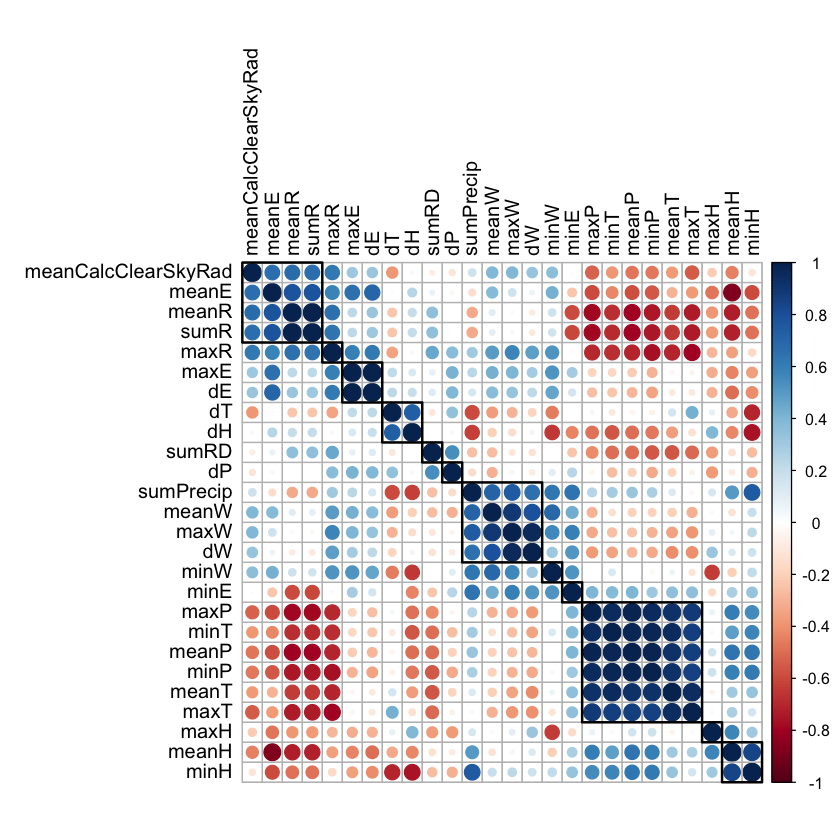

In [19]:
x_24 %>%
  select(meanT:meanCalcClearSkyRad) %>%
  get_corrPlot(n_modules=12)

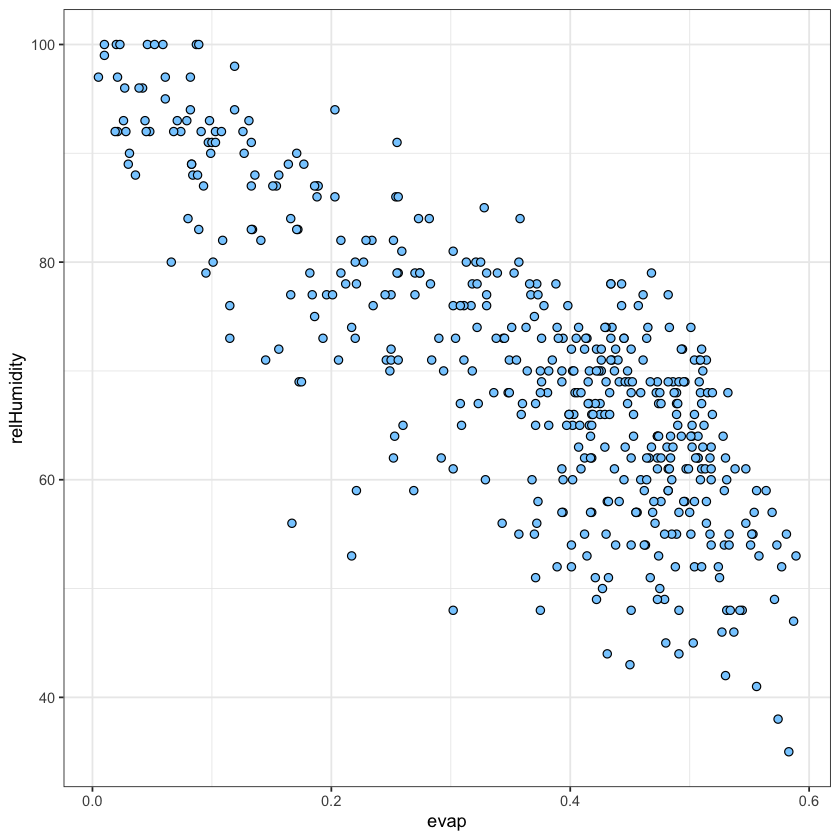

In [20]:
weather_df_hourly %>% 
  filter(MonthDay >= '1904-5-01' & MonthDay < '1904-10-01') %>% 
  filter(HOUR == 1000) %>%
  ggplot(., aes(x=evap, y=relHumidity)) +
    geom_point(shape=21, fill='skyblue1', size=2) + 
    theme_bw()
  

In [21]:
# 24 ZTE hours before sampling

sub_weather_df_zte <- weather_df_hourly %>% 
  filter((Date %in% as.Date(days_of_sampling) & HOUR <= 800) | 
    (Date %in% as.Date(days_before_sampling) & HOUR >= 600 ))

sub_weather_df_zte <- sub_weather_df_zte %>%
  filter ((MONTH == 5 & DAY == 21 & YEAR == 2017 & HOUR >= 700) | 
          (MONTH == 5 & DAY == 22 & YEAR == 2017 & HOUR < 700) | 
          (MONTH == 7 & DAY == 29 & YEAR == 2017 & HOUR >= 700) | 
          (MONTH == 7 & DAY == 30 & YEAR == 2017 & HOUR < 700) | 
          (MONTH == 9 & DAY == 24 & YEAR == 2017 & HOUR >= 800) | 
          (MONTH == 9 & DAY == 25 & YEAR == 2017 & HOUR < 800) | 
          
          (MONTH == 5 & DAY == 29 &  YEAR == 2018 & HOUR >= 600) | 
          (MONTH == 5 & DAY == 30 &  YEAR == 2018 & HOUR < 600) | 
          (MONTH == 7 & DAY == 31 &  YEAR == 2018 & HOUR >= 700) | 
          (MONTH == 8 & DAY == 1 &  YEAR == 2018 & HOUR < 700) | 
          (MONTH == 9 & DAY == 16 &  YEAR == 2018 & HOUR >= 700) | 
          (MONTH == 9 & DAY == 17 & YEAR == 2018 & HOUR < 700) | 
          
          (MONTH == 5 & DAY == 22 & YEAR == 2019 & HOUR >= 700) | 
          (MONTH == 5 & DAY == 23 & YEAR == 2019 & HOUR < 700) | 
          (MONTH == 8 & DAY == 4 & YEAR == 2019 & HOUR >= 700) | 
          (MONTH == 8 & DAY == 5 & YEAR == 2019 & HOUR < 700) | 
          (MONTH == 9 & DAY == 16 & YEAR == 2019 & HOUR >= 700) | 
          (MONTH == 9 & DAY == 17 & YEAR == 2019 & HOUR < 700)
         )



group_id <- c()
for (date in sub_weather_df_zte$Date){
    x <- which(as.Date(days_of_sampling) == date)
    y <- which(as.Date(days_before_sampling) == date)
    if (length(x) == 1){
        group_id <- c(group_id, x)
    } else {
        group_id <- c(group_id, y)
    }
}

table(group_id)
sub_weather_df_zte$group <- group_id
table(sub_weather_df_zte$group)

group_id
 1  2  3  4  5  6  7  8  9 
24 24 24 24 24 24 24 24 24 


 1  2  3  4  5  6  7  8  9 
24 24 24 24 24 24 24 24 24 

In [22]:
x <- sub_weather_df_zte %>% 
  group_by(group) %>%
  summarise(meanT=mean(avgT),
            maxT=max(avgT),
            minT=min(avgT), 
            dT=max(avgT) - min(avgT),
            sumPrecip=sum(precip),
            meanW=mean(windSpeed),
            maxW=max(windSpeed),
            minW=min(windSpeed), 
            dW=max(windSpeed) - min(windSpeed),
            meanH=mean(relHumidity),
            maxH=max(relHumidity),
            minH=min(relHumidity), 
            dH=max(relHumidity) - min(relHumidity),
            meanR=mean(avgSolarRad),
            maxR=max(avgSolarRad),
            #minR=min(avgSolarRad),  #always 0
            #dR=max(avgSolarRad) - min(avgSolarRad), # always maxR
            sumR=sum(totalSolarRad),
            sumRD=sum(totalSolarRadDensity),
            meanP=mean(pressure),
            maxP=max(pressure),
            minP=min(pressure), 
            dP=max(pressure) - min(pressure),
            meanE=mean(evap),
            maxE=max(evap),
            minE=min(evap), 
            dE=max(evap) - min(evap),
            meanCalcClearSkyRad=mean(calcClearSkyRad)
           )

In [23]:
x_zte <- as.data.frame(x)
apply(X=x_zte, FUN=sd, MARGIN=2)

group               meanT                maxT                minT 
       2.738613e+00        3.255313e+00        3.453420e+00        2.805352e+00 
                 dT           sumPrecip               meanW                maxW 
       1.174498e+00        1.901734e+01        1.065152e+00        1.500000e+00 
               minW                  dW               meanH                maxH 
       4.409586e-01        1.301708e+00        5.070767e+00        3.807887e+00 
               minH                  dH               meanR                maxR 
       7.172478e+00        6.906116e+00        4.026727e+01        9.635669e+01 
               sumR               sumRD               meanP                maxP 
       3.448820e+03        8.781578e+01        3.670134e+00        3.572620e+00 
               minP                  dP               meanE                maxE 
       4.260868e+00        2.346688e+00        2.941950e-02        5.655528e-02 
               minE                  dE meanCalcClearSkyRad 
       7.763876e-03        5.469486e-02        1.804397e-01

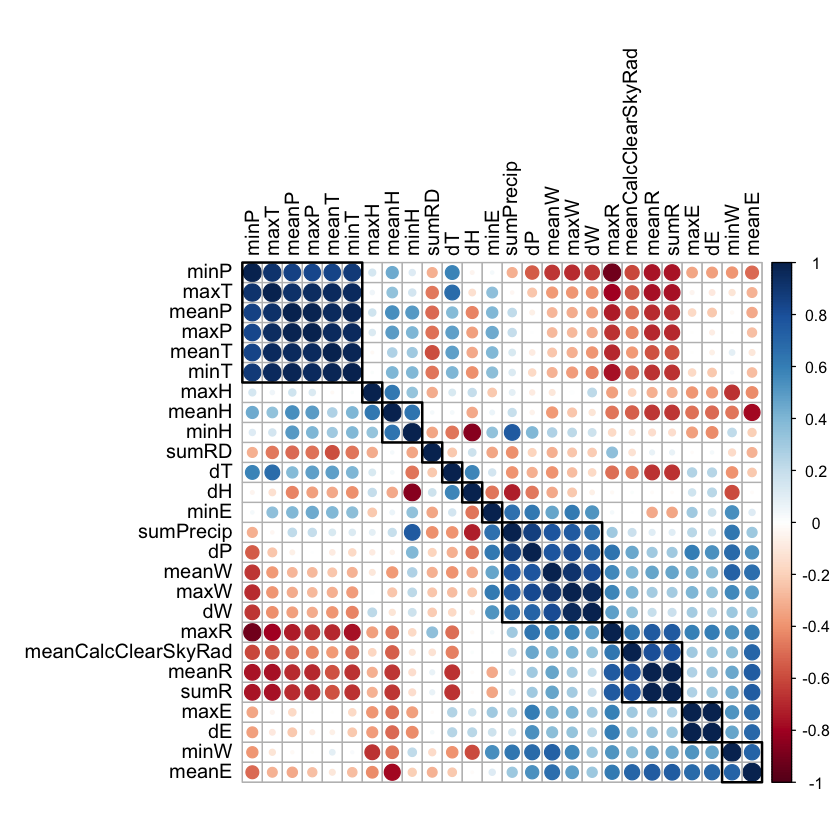

In [24]:
x_zte %>% 
  select(meanT:meanCalcClearSkyRad) %>%
  get_corrPlot(n_modules=12)

In [25]:
colnames(x_24) <- paste(colnames(x_24), '24', sep='_')
colnames(x_zte) <- paste(colnames(x_zte), 'zte', sep='_')

In [26]:
x <- merge(x_24, x_zte, by.x='group_24', by.y='group_zte')

In [27]:
pdf('weather_figures/1719_weather_24zte_comp.pdf', width=12, height=12)

x %>%
  select(-group_24) %>%
  get_corrPlot(n_modules=length(colnames(x_24)) + 3)

dev.off()

pdf 
  2

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


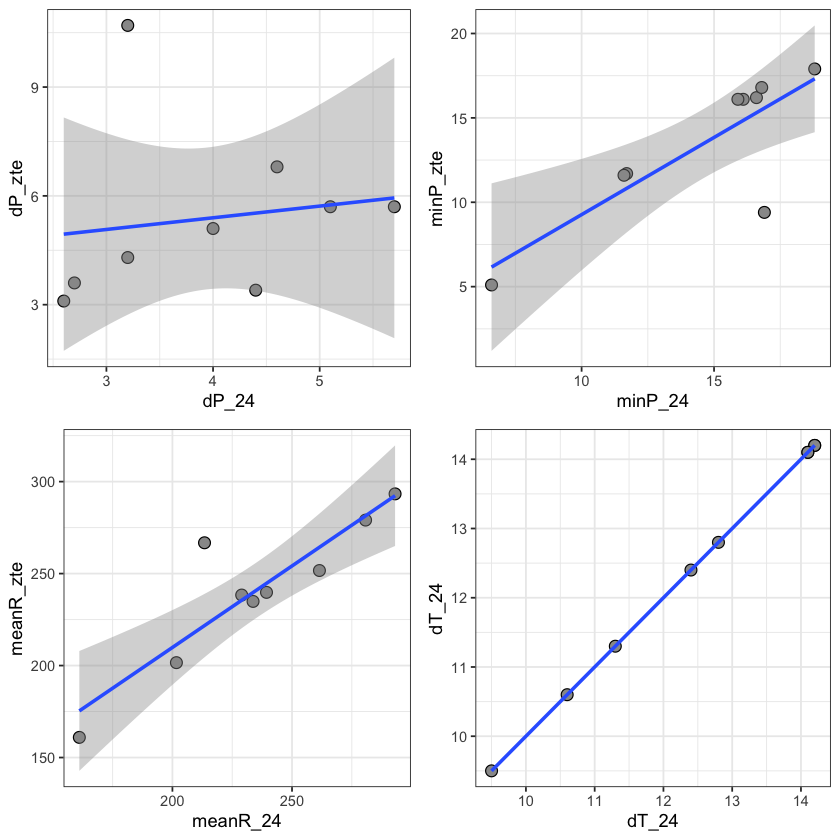

In [28]:
aa <- ggplot(x, aes(x=dP_24, y=dP_zte)) + 
  geom_point(shape=21, fill='grey60', size=3) + 
  stat_smooth(method='lm') + 
  theme_bw()

bb <- ggplot(x, aes(x=minP_24, y=minP_zte)) + 
  geom_point(shape=21, fill='grey60', size=3) + 
  stat_smooth(method='lm') + 
  theme_bw()

cc <- ggplot(x, aes(x=meanR_24, y=meanR_zte)) + 
  geom_point(shape=21, fill='grey60', size=3) + 
  stat_smooth(method='lm') + 
  theme_bw()

dd <- ggplot(x, aes(x=dT_24, y=dT_24)) + 
  geom_point(shape=21, fill='grey60', size=3) + 
  stat_smooth(method='lm') + 
  theme_bw()

ggpubr::ggarrange(aa, bb, cc, dd,
                  nrow=2, ncol=2)

From above, it looks like using a 24 hour window before sampling is not going to be functionally different using the 24 zietgeber time. As such, I will stick with the 24-hour before sampling. 

Now we can ask is 24 hours before ~each vine was sampled should vary at all.  Below, I will take 24 hour snapshots from each hour in the sampling window and check that they correlate as strongly as the 24-hour/24-zte correlations. 

## Now, make a function to build the sliding 24-hout windows

In [29]:
sample_24_hours_from_time <- function(weather_df_hourly, start_time){

    sub_weather_df_hourly <- weather_df_hourly %>% 
      filter((Date %in% as.Date(days_of_sampling) & HOUR <= start_time) | 
        (Date %in% as.Date(days_before_sampling) & HOUR > start_time ))

    group_id <- c()
    for (date in sub_weather_df_hourly$Date){
        x <- which(as.Date(days_of_sampling) == date)
        y <- which(as.Date(days_before_sampling) == date)
        if (length(x) == 1){
            group_id <- c(group_id, x)
        } else {
            group_id <- c(group_id, y)
        }
    }

    sub_weather_df_hourly$group <- group_id
    print(table(sub_weather_df_hourly$group))
    
    x <- sub_weather_df_hourly %>% 
      group_by(group) %>%
      summarise(meanT=mean(avgT),
                maxT=max(avgT),
                minT=min(avgT), 
                dT=max(avgT) - min(avgT),
                sumPrecip=sum(precip),
                meanW=mean(windSpeed),
                maxW=max(windSpeed),
                minW=min(windSpeed), 
                dW=max(windSpeed) - min(windSpeed),
                meanH=mean(relHumidity),
                maxH=max(relHumidity),
                minH=min(relHumidity), 
                dH=max(relHumidity) - min(relHumidity),
                meanR=mean(avgSolarRad),
                maxR=max(avgSolarRad),
                #minR=min(avgSolarRad),  #always 0
                #dR=max(avgSolarRad) - min(avgSolarRad), # always maxR
                sumR=sum(totalSolarRad),
                sumRD=sum(totalSolarRadDensity),
                meanP=mean(pressure),
                maxP=max(pressure),
                minP=min(pressure), 
                dP=max(pressure) - min(pressure),
                meanE=mean(evap),
                maxE=max(evap),
                minE=min(evap), 
                dE=max(evap) - min(evap),
                meanCalcClearSkyRad=mean(calcClearSkyRad)
           )
    return(x)
}

check_correlations <- function(x1, x2){
    x <- merge(x1, x2, by='group')
    
    cormat <- x %>%
      select(-group) %>% 
      cor(x)

    for (col in colnames(x1)){
        if (col != 'group'){
            corr <- cormat[paste(col, '.x', sep=''), paste(col, '.y', sep='')]
            print(str_interp('${col} corrlation == ${corr}'))
        }
    }
}

In [30]:
weather_1000 <- sample_24_hours_from_time(weather_df_hourly, 1000)
weather_1100 <- sample_24_hours_from_time(weather_df_hourly, 1100)
weather_1200 <- sample_24_hours_from_time(weather_df_hourly, 1200)
weather_1300 <- sample_24_hours_from_time(weather_df_hourly, 1300)


x_11 <- merge(weather_1000, weather_1100, by='group')
x_12 <- merge(weather_1000, weather_1200, by='group')
x_13 <- merge(weather_1000, weather_1300, by='group')


 1  2  3  4  5  6  7  8  9 
24 24 24 24 24 24 24 24 24 

 1  2  3  4  5  6  7  8  9 
24 24 24 24 24 24 24 24 24 

 1  2  3  4  5  6  7  8  9 
24 24 24 24 24 24 24 24 24 

 1  2  3  4  5  6  7  8  9 
24 24 24 24 24 24 24 24 24 


In [31]:
check_correlations(weather_1000, weather_1100)
print('===========')
check_correlations(weather_1000, weather_1200)
print('===========')
check_correlations(weather_1000, weather_1300)

[1] "meanT corrlation == 0.999650867679723"
[1] "maxT corrlation == 0.999848148010511"
[1] "minT corrlation == 1"
[1] "dT corrlation == 0.997264183304143"
[1] "sumPrecip corrlation == 1"
[1] "meanW corrlation == 0.998716885179492"
[1] "maxW corrlation == 1"
[1] "minW corrlation == 1"
[1] "dW corrlation == 1"
[1] "meanH corrlation == 0.999055318986786"
[1] "maxH corrlation == 1"
[1] "minH corrlation == 1"
[1] "dH corrlation == 1"
[1] "meanR corrlation == 0.995503384198851"
[1] "maxR corrlation == 0.995921605187577"
[1] "sumR corrlation == 0.995462715586357"
[1] "sumRD corrlation == 0.999138554658428"
[1] "meanP corrlation == 0.999652415535349"
[1] "maxP corrlation == 0.99876653193853"
[1] "minP corrlation == 1"
[1] "dP corrlation == 0.985830191699684"
[1] "meanE corrlation == 0.993952364213935"
[1] "maxE corrlation == 1"
[1] "minE corrlation == 1"
[1] "dE corrlation == 1"
[1] "meanCalcClearSkyRad corrlation == 0.999987317569739"
[1] "==========="
[1] "meanT corrlation == 0.9989789517598

Even at the four hour offset, it looks like there is a really strong correlation in most environmental features. Like in the comparison between 24 hour before start and 24-zte, there largest difference is in dP, but those differences here are much smaller. 

The final thing to look at this whether or not those summaries vary wildly on smaller windows. For example, 4 or 6 hour windows. 

## Check smaller windows

In [32]:
sample_n_hours_from_time <- function(weather_df_hourly, start_time, n_hours){

    sub_weather_df_hourly <- weather_df_hourly %>% 
      filter((Date %in% as.Date(days_of_sampling) & 
              HOUR <= start_time &
              HOUR > start_time - n_hours*100))

    group_id <- c()
    
    # dumb but should still work
    for (date in sub_weather_df_hourly$Date){
        x <- which(as.Date(days_of_sampling) == date)
        y <- which(as.Date(days_before_sampling) == date)
        if (length(x) == 1){
            group_id <- c(group_id, x)
        } else {
            group_id <- c(group_id, y)
        }
    }

    sub_weather_df_hourly$group <- group_id
    print(table(sub_weather_df_hourly$group))
    
    x <- sub_weather_df_hourly %>% 
      group_by(group) %>%
      summarise(meanT=mean(avgT),
                maxT=max(avgT),
                minT=min(avgT), 
                dT=max(avgT) - min(avgT),
                sumPrecip=sum(precip),
                meanW=mean(windSpeed),
                maxW=max(windSpeed),
                minW=min(windSpeed), 
                dW=max(windSpeed) - min(windSpeed),
                meanH=mean(relHumidity),
                maxH=max(relHumidity),
                minH=min(relHumidity), 
                dH=max(relHumidity) - min(relHumidity),
                meanR=mean(avgSolarRad),
                maxR=max(avgSolarRad),
                minR=min(avgSolarRad),  #not always 0
                dR=max(avgSolarRad) - min(avgSolarRad), # not always maxR
                sumR=sum(totalSolarRad),
                sumRD=sum(totalSolarRadDensity),
                meanP=mean(pressure),
                maxP=max(pressure),
                minP=min(pressure), 
                dP=max(pressure) - min(pressure),
                meanE=mean(evap),
                maxE=max(evap),
                minE=min(evap), 
                dE=max(evap) - min(evap),
                meanCalcClearSkyRad=mean(calcClearSkyRad)
           )
    return(x)
}

In [33]:
weather_1000_6 <- sample_n_hours_from_time(weather_df_hourly, 1000, 6)
weather_1000_4 <- sample_n_hours_from_time(weather_df_hourly, 1000, 4)

check_correlations(weather_1000_4, weather_1000_6)


1 2 3 4 5 6 7 8 9 
6 6 6 6 6 6 6 6 6 

1 2 3 4 5 6 7 8 9 
4 4 4 4 4 4 4 4 4 
[1] "meanT corrlation == 0.96144468363445"
[1] "maxT corrlation == 1"
[1] "minT corrlation == 0.954970329981844"
[1] "dT corrlation == 0.903768449182789"
[1] "sumPrecip corrlation == 1"
[1] "meanW corrlation == 0.963650832605341"
[1] "maxW corrlation == 0.964901281354016"
[1] "minW corrlation == 0.596480908063461"
[1] "dW corrlation == 0.805161048316106"
[1] "meanH corrlation == 0.968083653839868"
[1] "maxH corrlation == 0.806165974934591"
[1] "minH corrlation == 1"
[1] "dH corrlation == 0.950511629732771"
[1] "meanR corrlation == 0.999628091793844"
[1] "maxR corrlation == 1"
[1] "minR corrlation == 0.25809596418709"
[1] "dR corrlation == 0.94641779521613"
[1] "sumR corrlation == 0.999639293751318"
[1] "sumRD corrlation == 0.998602597725486"
[1] "meanP corrlation == 0.996414859435346"
[1] "maxP corrlation == 1"
[1] "minP corrlation == 0.991460706516003"
[1] "dP corrlation == 0.929403400072924"
[1] "meanE corr

In [34]:
check_correlations(weather_1000_4, weather_1000_6)

[1] "meanT corrlation == 0.96144468363445"
[1] "maxT corrlation == 1"
[1] "minT corrlation == 0.954970329981844"
[1] "dT corrlation == 0.903768449182789"
[1] "sumPrecip corrlation == 1"
[1] "meanW corrlation == 0.963650832605341"
[1] "maxW corrlation == 0.964901281354016"
[1] "minW corrlation == 0.596480908063461"
[1] "dW corrlation == 0.805161048316106"
[1] "meanH corrlation == 0.968083653839868"
[1] "maxH corrlation == 0.806165974934591"
[1] "minH corrlation == 1"
[1] "dH corrlation == 0.950511629732771"
[1] "meanR corrlation == 0.999628091793844"
[1] "maxR corrlation == 1"
[1] "minR corrlation == 0.25809596418709"
[1] "dR corrlation == 0.94641779521613"
[1] "sumR corrlation == 0.999639293751318"
[1] "sumRD corrlation == 0.998602597725486"
[1] "meanP corrlation == 0.996414859435346"
[1] "maxP corrlation == 1"
[1] "minP corrlation == 0.991460706516003"
[1] "dP corrlation == 0.929403400072924"
[1] "meanE corrlation == 0.998058281275631"
[1] "maxE corrlation == 1"
[1] "minE corrlation =

In [35]:
colnames(weather_1000) <- paste(colnames(weather_1000), '_24', sep='')
colnames(weather_1000_4) <- paste(colnames(weather_1000_4), '_04', sep='')
colnames(weather_1000_6) <- paste(colnames(weather_1000_6), '_06', sep='')

In [36]:
x <- merge(weather_1000, weather_1000_4, by.x='group_24', by.y='group_04') %>% 
  select(-group_24)

pdf('weather_figures/1719_weather_2404_comp.pdf', height=12, width=12)
  get_corrPlot(x, n_modules=27)
dev.off()

pdf 
  2

In [37]:
x <- merge(weather_1000_4, weather_1000_6, by.x='group_04', by.y='group_06') %>% 
  select(-group_04)

pdf('weather_figures/1719_weather_0406_comp.pdf', height=12, width=12)
  get_corrPlot(x, n_modules=22)
dev.off()

pdf 
  2

In [38]:
## Possibly Need to run on 24 hours and 4/6 hours
pdf('weather_figures/1719_weather_24hour_summary.pdf', height=8, width=8)
weather_1000 %>% 
  select(-group_24) %>% 
  get_corrPlot(n_modules=15)
dev.off()

pdf('weather_figures/1719_weather_04hour_summary.pdf', height=8, width=8)
weather_1000_4 %>% 
  select(-group_04) %>% 
  get_corrPlot(n_modules=15)
dev.off()

pdf 
  2

pdf 
  2

`geom_smooth()` using formula 'y ~ x'


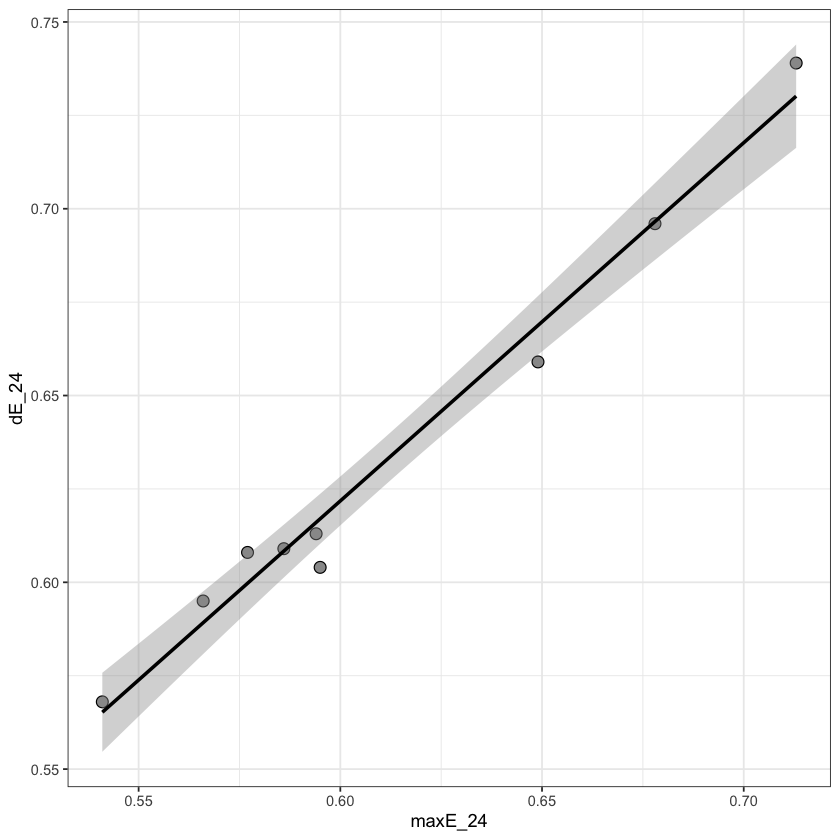

In [39]:
ggplot(weather_1000, aes(x=maxE_24, y=dE_24)) + 
  geom_point(shape=21, fill='grey60', size=3) + 
  stat_smooth(method='lm', color='black', fill='grey60') + 
  theme_bw()

In [40]:
pca <- weather_1000 %>% 
  select(-group_24) %>%
  prcomp(center=T, scale=T)

pcax <- as.data.frame(pca$x)
summary(pca)

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     3.2149 2.3950 1.8515 1.6396 1.45998 0.94420 0.74835
Proportion of Variance 0.3975 0.2206 0.1318 0.1034 0.08198 0.03429 0.02154
Cumulative Proportion  0.3975 0.6181 0.7500 0.8534 0.93536 0.96965 0.99119
                           PC8       PC9
Standard deviation     0.47850 6.206e-15
Proportion of Variance 0.00881 0.000e+00
Cumulative Proportion  1.00000 1.000e+00

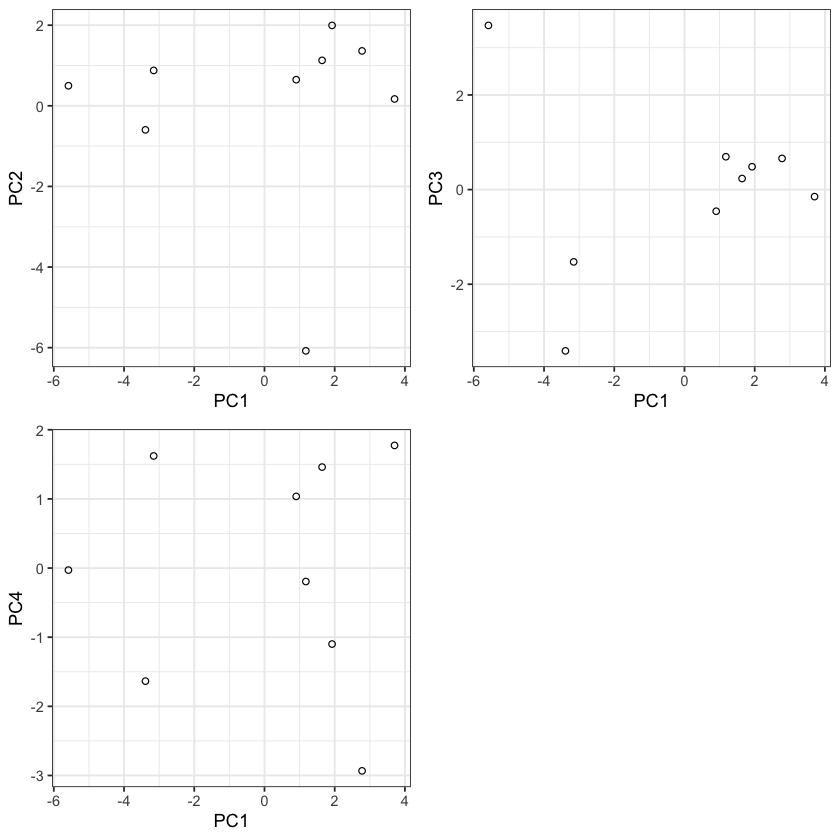

In [41]:
aa <- ggplot(pcax, aes(PC1, PC2)) + 
  geom_point(shape=21) + 
  theme_bw()

bb <- ggplot(pcax, aes(PC1, PC3)) + 
  geom_point(shape=21) + 
  theme_bw()

cc <- ggplot(pcax, aes(PC1, PC4)) + 
  geom_point(shape=21) + 
  theme_bw()

ggpubr::ggarrange(aa, bb, cc, 
                  nrow=2, ncol=2)

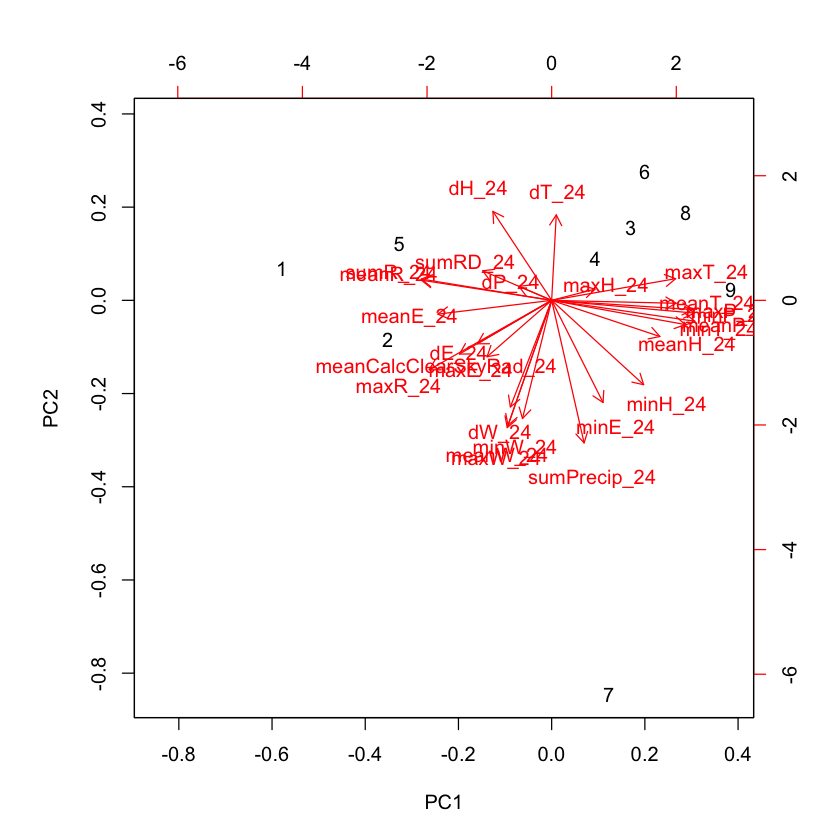

In [42]:
biplot(pca)

In [43]:
pcax$Date <- days_of_sampling

write.csv(pcax, '1719_weather_constructedFeatures.csv')

## Build Full PCs and sample from that space

In [44]:
sample_24_hours_from_time <- function(weather_df_hourly, start_time){

    sub_weather_df_hourly <- weather_df_hourly %>% 
      filter((Date %in% as.Date(days_of_sampling) & HOUR <= start_time) | 
        (Date %in% as.Date(days_of_sampling) & HOUR > start_time ))

    group_id <- c()
    for (date in sub_weather_df_hourly$Date){
        x <- which(as.Date(days_of_sampling) == date)
        y <- which(as.Date(days_before_sampling) == date)
        if (length(x) == 1){
            group_id <- c(group_id, x)
        } else {
            group_id <- c(group_id, y)
        }
    }

    print(dim(sub_weather_df_hourly))
    print(length(group_id))
    sub_weather_df_hourly$group <- group_id
    print(table(sub_weather_df_hourly$group))
    
    x <- sub_weather_df_hourly %>% 
      group_by(group) %>%
      summarise(meanT=mean(avgT),
                maxT=max(avgT),
                minT=min(avgT), 
                dT=max(avgT) - min(avgT),
                sumPrecip=sum(precip),
                meanW=mean(windSpeed),
                maxW=max(windSpeed),
                minW=min(windSpeed), 
                dW=max(windSpeed) - min(windSpeed),
                meanH=mean(relHumidity),
                maxH=max(relHumidity),
                minH=min(relHumidity), 
                dH=max(relHumidity) - min(relHumidity),
                meanR=mean(avgSolarRad),
                maxR=max(avgSolarRad),
                #minR=min(avgSolarRad),  # not always 0
                #dR=max(avgSolarRad) - min(avgSolarRad), # not always maxR
                sumR=sum(totalSolarRad),
                sumRD=sum(totalSolarRadDensity),
                meanP=mean(pressure),
                maxP=max(pressure),
                minP=min(pressure), 
                dP=max(pressure) - min(pressure),
                meanE=mean(evap),
                maxE=max(evap),
                minE=min(evap), 
                dE=max(evap) - min(evap),
                meanCalcClearSkyRad=mean(calcClearSkyRad)
           )
    return(x)
}


In [45]:
days_of_sampling <- unique(weather_df_hourly$Date)[2:length(unique(weather_df_hourly$Date))]
days_before_sampling <- days_of_sampling - 1

x <- sample_24_hours_from_time(weather_df_hourly, start_time=1000)
x$Date <- days_of_sampling
colnames(x)

[1] 26256    17
[1] 26256

   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
  24   24   24   24   24   24   24   24   24   24   24   24   24   24   24   24 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
  24   24   24   24   24   24   24   24   24   24   24   24   24   24   24   24 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
  24   24   24   24   24   24   24   24   24   24   24   24   24   24   24   24 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
  24   24   24   24   24   24   24   24   24   24   24   24   24   24   24   24 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
  24   24   24   24   24   24   24   24   24   24   24   24   24   24   24   24 
  81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96 
  24   24   24   24   24   24   24   24   24   24   24   24   24   24   24   24 
 

[1] "group"               "meanT"               "maxT"               
 [4] "minT"                "dT"                  "sumPrecip"          
 [7] "meanW"               "maxW"                "minW"               
[10] "dW"                  "meanH"               "maxH"               
[13] "minH"                "dH"                  "meanR"              
[16] "maxR"                "sumR"                "sumRD"              
[19] "meanP"               "maxP"                "minP"               
[22] "dP"                  "meanE"               "maxE"               
[25] "minE"                "dE"                  "meanCalcClearSkyRad"
[28] "Date"

In [46]:
pca <- x %>%
  select(meanT:meanCalcClearSkyRad) %>%
  prcomp(center=T, scale=T)

pcax <- as.data.frame(pca$x)
pcax$Date <- as.Date(days_of_sampling)

In [47]:
md <- weather_df_hourly %>% 
  select(Date, MonthDay) %>%
  unique()

pcax$MonthDay <- md$MonthDay[2:length(md$MonthDay)]

In [48]:
summary(pca)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     3.2763 2.3142 1.9184 1.28901 0.98699 0.88272 0.79047
Proportion of Variance 0.4128 0.2060 0.1415 0.06391 0.03747 0.02997 0.02403
Cumulative Proportion  0.4128 0.6188 0.7604 0.82427 0.86174 0.89171 0.91574
                           PC8    PC9   PC10    PC11    PC12    PC13    PC14
Standard deviation     0.77208 0.6841 0.6183 0.53057 0.44513 0.29800 0.25802
Proportion of Variance 0.02293 0.0180 0.0147 0.01083 0.00762 0.00342 0.00256
Cumulative Proportion  0.93867 0.9567 0.9714 0.98220 0.98982 0.99324 0.99580
                          PC15   PC16    PC17    PC18    PC19    PC20     PC21
Standard deviation     0.24196 0.1836 0.08175 0.07183 0.06710 0.02493 0.004041
Proportion of Variance 0.00225 0.0013 0.00026 0.00020 0.00017 0.00002 0.000000
Cumulative Proportion  0.99805 0.9993 0.99960 0.99980 0.99998 1.00000 1.000000
                            PC22     PC23     

In [49]:
year(pcax$Date)

[1] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
  [15] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
  [29] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
  [43] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
  [57] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
  [71] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
  [85] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
  [99] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [113] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [127] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [141] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [155] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [169] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [183] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [197] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [211] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [225] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [239] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [253] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [267] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [281] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [295] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [309] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [323] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [337] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [351] 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017 2017
 [365] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [379] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [393] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [407] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [421] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [435] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [449] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [463] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [477] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [491] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [505] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [519] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [533] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [547] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [561] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [575] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [589] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [603] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [617] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [631] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [645] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [659] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [673] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [687] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [701] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018
 [715] 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 2018

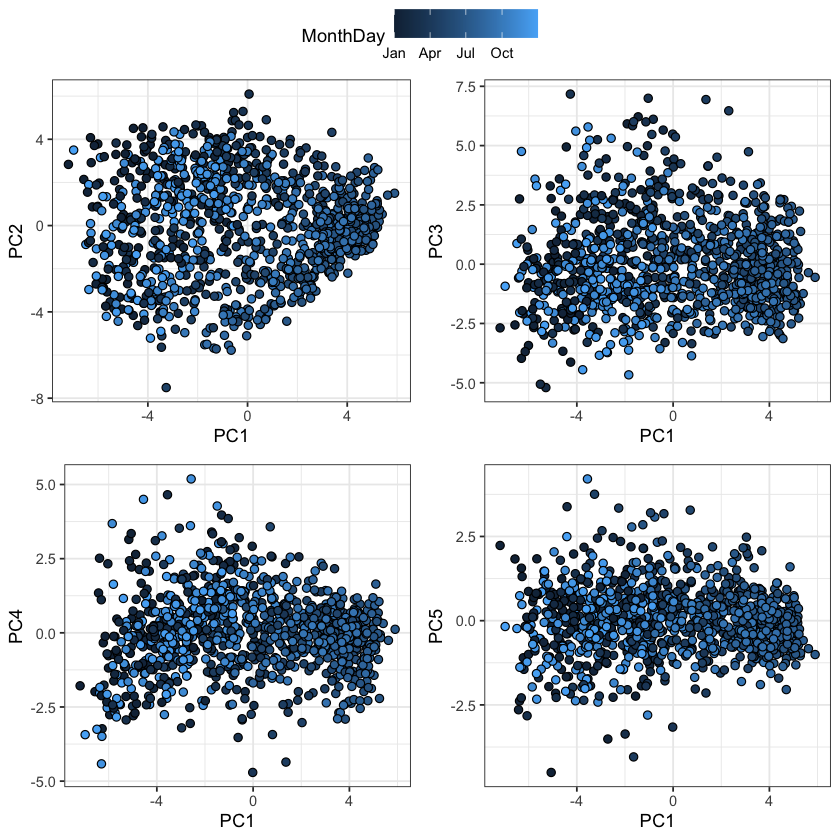

In [50]:
aa <- ggplot(pcax, aes(x=PC1, y=PC2, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

bb <- ggplot(pcax, aes(x=PC1, y=PC3, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

cc <- ggplot(pcax, aes(x=PC1, y=PC4, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

dd <- ggplot(pcax, aes(x=PC1, y=PC5, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

ggpubr::ggarrange(aa, bb, cc, dd, 
                  nrow=2, ncol=2, common.legend=T)

In [62]:
library('ggfortify')

In [114]:
head(pcax)$MonthDay - as_date("1904-01-01")

Time differences in days
[1] 1 2 3 4 5 6

In [159]:
#biplot(pca, xlabs=rep('.', nrow(pcax)), col = c("grey50", "deeppink3"))

# autoplot(pca, shape=21, fill='grey80', size=2, alpha=0.7, stroke=1.2, variance_percentage = T,
#          loadings = TRUE,         
#          loadings.colour = 'deeppink3',
#          loadings.label = TRUE, 
#          loadings.label.size = 3,
#         ) + theme_bw()

pcarot <- as.data.frame(pca$rotation)

pcax <- pcax %>%
 mutate(int_date = as.numeric(MonthDay-as_date("1904-01-01")))

pdf('1719_weather_PCAbiplot.pdf', height=8, width=8)
ggplot(pcax, aes(x=PC1, y=PC2)) + 
  geom_point(aes(color=int_date), size=2) + 
  scale_color_gradient2(low='firebrick1', midpoint=365/2, mid='grey90', high='dodgerblue') + 
  geom_segment(data=pcarot, aes(PC1*20, PC2*20, xend=0, yend=0), lwd=0.9, col="grey25") +
  geom_text(data=pcarot, aes(PC1*23, PC2*23), col="grey25", label=rownames(pcarot)) +
  theme_bw()
dev.off()



pdf 
  2

In [28]:
days_of_sampling <- c('2017-05-22', '2017-07-30', '2017-09-25', 
                      '2018-05-30', '2018-08-01', '2018-09-17', 
                      '2019-05-23', '2019-08-05', '2019-09-17')

pcax_filt <- pcax %>%
  filter(Date %in% as.Date(days_of_sampling))

dim(pcax_filt)

[1]  9 28

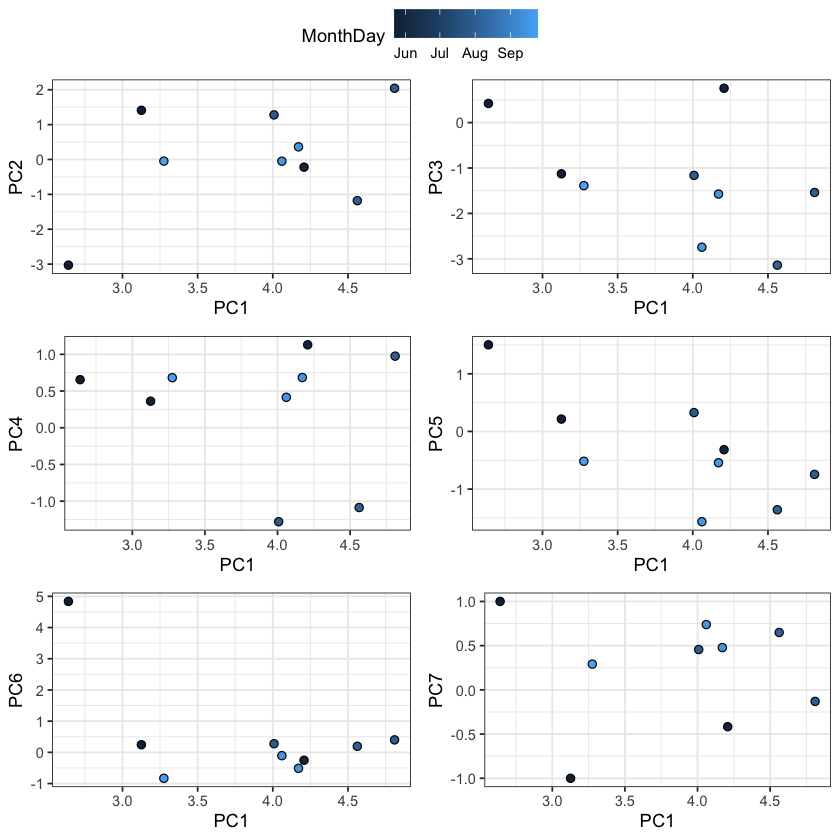

In [31]:
aa <- ggplot(pcax_filt, aes(x=PC1, y=PC2, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

bb <- ggplot(pcax_filt, aes(x=PC1, y=PC3, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

cc <- ggplot(pcax_filt, aes(x=PC1, y=PC4, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

dd <- ggplot(pcax_filt, aes(x=PC1, y=PC5, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

ee <- ggplot(pcax_filt, aes(x=PC1, y=PC6, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

ff <- ggplot(pcax_filt, aes(x=PC1, y=PC7, fill=MonthDay)) + 
  geom_point(shape=21, size=2) + 
  theme_bw()

ggpubr::ggarrange(aa, bb, cc, dd, ee, ff,
                  nrow=3, ncol=2, common.legend=T)

In [32]:
write.csv(pcax_filt, '1719_weather_constructedFeatures_fullDataPCA.csv')

In [40]:
write.csv(pca$rotation, '1719_weather_constructedFeatures_fullDataPCA_rotation.csv')

# Functional Enrichment by Hand

In [4]:
ipr_scan <- read.csv('../vitvi.vcostv3.clean.pep.txt', sep='\t')
head(ipr_scan)

genename,sequence_md5,sequence_length,analysis,signature_accession,signature_description,start,end,e.value,status,date,ipr_accession,ipr_description,go_term,pathway_annotation
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,Pfam,PF13418,"Galactose oxidase, central domain",197,247,7.70e-07,TRUE,30-05-2019,,,,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,Pfam,PF13418,"Galactose oxidase, central domain",248,296,5.70e-06,TRUE,30-05-2019,,,,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,SUPERFAMILY,SSF57997,,572,707,3.04e-05,TRUE,30-05-2019,,,,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,SUPERFAMILY,SSF117281,,73,341,4.32e-56,TRUE,30-05-2019,IPR015915,Kelch-type beta propeller,GO:0005515,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,Gene3D,G3DSA:2.120.10.80,,72,349,1.20e-44,TRUE,30-05-2019,IPR015915,Kelch-type beta propeller,GO:0005515,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,Pfam,PF01344,Kelch motif,88,128,1.20e-06,TRUE,30-05-2019,IPR006652,Kelch repeat type 1,GO:0005515,


In [101]:
## need to filter for genes tested in DGE analysis

ipr_sub <- ipr_scan %>% 
  select(genename, e.value, ipr_accession) %>%
  filter(e.value < 1e-05) %>% 
  filter(ipr_accession != '') %>%
  select(genename, ipr_accession) %>%
  unique()

#also grab pfam
pfam_sub <- ipr_scan %>% 
  select(genename, analysis, signature_accession, signature_description, e.value, ipr_accession) %>%
  filter(e.value < 1e-05) %>% 
  filter(analysis == 'Pfam') %>%
  select(genename, signature_accession, signature_description, ipr_accession) %>%
  unique()

In [102]:
pfam_sub

,genename,signature_accession,signature_description,ipr_accession
1,Vitvi05g00341.t01,PF13418,"Galactose oxidase, central domain",
3,Vitvi05g00341.t01,PF01344,Kelch motif,IPR006652
4,Vitvi07g02478.t01,PF13962,Domain of unknown function,IPR026961
5,Vitvi15g00585.t01,PF07797,Protein of unknown function (DUF1639),IPR012438
6,Vitvi16g02000.t01,PF00069,Protein kinase domain,IPR000719
7,Vitvi16g02000.t01,PF13947,Wall-associated receptor kinase galacturonan-binding,IPR025287
8,Vitvi16g00435.t01,PF13855,Leucine rich repeat,IPR001611
9,Vitvi16g00435.t01,PF08263,Leucine rich repeat N-terminal domain,IPR013210
10,Vitvi04g00343.t01,PF00271,Helicase conserved C-terminal domain,IPR001650
11,Vitvi04g00343.t01,PF00270,DEAD/DEAH box helicase,IPR011545


In [73]:
example_dataset <- read.csv('all_rootstock_comparisons/Leaf_2018_Harvest_Ungrafted-1103P.csv')
all_genes <- paste(example_dataset$X, '.t01', sep='')

set_of_genes <- example_dataset %>%
  filter(padj < 0.05 & log2FoldChange > 0) %>%
  .[['X']] %>%
  paste('.t01', sep='')

length(set_of_genes)

[1] 4415

In [104]:
ipr_sub_mtv <- ipr_sub %>%
  filter(genename %in% all_genes)

pfam_sub_mtv <- pfam_sub %>%
  filter(genename %in% all_genes)

dim(ipr_sub_mtv)
dim(pfam_sub_mtv)

[1] 50361     2

[1] 24891     4

In [119]:
full_enrichment_test <- function(set_of_genes, ipr_sub, print_res=FALSE){
    ipr_testset <- ipr_sub[ipr_sub$genename %in% set_of_genes,]
    terms <- unique(ipr_testset$ipr_accession)
    
    print(str_interp("analyzing ${length(terms)} IPR accessions..."))
    
    enriched_terms <- c()
    for (term in terms){
        
        genes_to_term_in_set <- nrow(ipr_testset[ipr_testset$ipr_accession == term,])
        genes_to_term_in_genome <- nrow(ipr_sub[ipr_sub$ipr_accession == term,])
        genes_not_term_in_genome <- 24769 - genes_to_term_in_genome
        size_of_set <- length(set_of_genes)
        
        test <- phyper(genes_to_term_in_set, genes_to_term_in_genome,
                       genes_not_term_in_genome, size_of_set, lower.tail=FALSE)
        
        if (test < 0.05/length(terms) & genes_to_term_in_genome >= 10){
            if (print_res == TRUE)
            print(c(term, test, genes_to_term_in_set, genes_to_term_in_genome))
            enriched_terms <- c(enriched_terms, term)
        }
        
    }
    
    return(enriched_terms)

}

full_pfam_enrichment_test <- function(set_of_genes, pfam_sub, print_res=FALSE){
    pfam_testset <- pfam_sub[pfam_sub$genename %in% set_of_genes,]
    terms <- unique(pfam_testset$signature_accession)
    
    print(str_interp("analyzing ${length(terms)} Pfam domains..."))
    
    enriched_terms <- c()
    for (term in terms){
        
        genes_to_term_in_set <- nrow(pfam_testset[pfam_testset$signature_accession == term,])
        genes_to_term_in_genome <- nrow(pfam_sub[pfam_sub$signature_accession == term,])
        genes_not_term_in_genome <- 24769 - genes_to_term_in_genome
        size_of_set <- length(set_of_genes)
        
        test <- phyper(genes_to_term_in_set, genes_to_term_in_genome,
                       genes_not_term_in_genome, size_of_set, lower.tail=FALSE)
        
        if (test < 0.05/length(terms) & genes_to_term_in_genome >= 10){
            if (print_res == TRUE){
                print(c(term, test, genes_to_term_in_set, genes_to_term_in_genome))
            }
            enriched_terms <- c(enriched_terms, term)
        }
        
    }
    
    return(enriched_terms)

}

In [108]:
eset <- full_enrichment_test(set_of_genes, ipr_sub_mtv)
pset <- full_pfam_enrichment_test(set_of_genes, pfam_sub_mtv)

[1] "analyzing 2634 IPR accessions..."
[1] "IPR013583"            "7.00175562608706e-06" "8"                   
[4] "11"                  
[1] "IPR025757"            "3.12170325421978e-07" "10"                  
[4] "13"                  
[1] "IPR004159"            "6.93261006123533e-08" "15"                  
[4] "23"                  
[1] "IPR012946"            "5.05674359501684e-12" "24"                  
[4] "35"                  
[1] "IPR000490"            "6.95443372984339e-08" "21"                  
[4] "39"                  
[1] "IPR017853"            "1.68710987209878e-05" "59"                  
[4] "200"                 
[1] "IPR006458"            "2.96041531720057e-07" "9"                   
[4] "11"                  
[1] "IPR036915"            "1.07341751878546e-05" "21"                  
[4] "49"                  
[1] "IPR004367"            "1.08415321460321e-07" "16"                  
[4] "26"                  
[1] "IPR013763"           "1.7438921620823e-05" "17"         

In [98]:
ipr_scan %>%
  select(ipr_accession, ipr_description) %>%
  unique() %>%
  filter(ipr_accession %in% eset)

ipr_accession,ipr_description
IPR013583,Phosphoribosyltransferase C-terminal
IPR025757,"Ternary complex factor MIP1, leucine-zipper"
IPR017853,Glycoside hydrolase superfamily
IPR004159,Putative S-adenosyl-L-methionine-dependent methyltransferase
IPR029058,Alpha/Beta hydrolase fold
IPR016140,Bifunctional inhibitor/plant lipid transfer protein/seed storage helical domain
IPR036312,Bifunctional inhibitor/plant lipid transfer protein/seed storage helical domain superfamily
IPR012946,X8 domain
IPR000490,Glycoside hydrolase family 17
IPR036893,SBP domain superfamily


In [109]:
ipr_scan %>%
  filter(analysis == 'Pfam') %>% 
  select(signature_accession, signature_description) %>%
  unique() %>%
  filter(signature_accession %in% pset)

signature_accession,signature_description
PF08372,Plant phosphoribosyltransferase C-terminal
PF14389,Leucine-zipper of ternary complex factor MIP1
PF03141,Putative S-adenosyl-L-methionine-dependent methyltransferase
PF00332,Glycosyl hydrolases family 17
PF07983,X8 domain
PF03110,SBP domain
PF07731,Multicopper oxidase
PF07732,Multicopper oxidase
PF00394,Multicopper oxidase
PF04844,"Transcriptional repressor, ovate"


In [120]:
## make whole analysis into a function

functional_enrichment <- function(file, ipr_scan, ipr_sub, pfam_sub){
    example_dataset <- read.csv(file)
    all_genes <- paste(example_dataset$X, '.t01', sep='')

    # get up regulated genes
    up_genes <- example_dataset %>%
      filter(padj < 0.05 & log2FoldChange > 0) %>%
      .[['X']] %>%
      paste('.t01', sep='')
    
    #get down regulated genes
    down_genes <- example_dataset %>%
      filter(padj < 0.05 & log2FoldChange < 0) %>%
      .[['X']] %>%
      paste('.t01', sep='')

    #filter for genes in DEG analysis
    ipr_sub_mtv <- ipr_sub %>%
      filter(genename %in% all_genes)

    pfam_sub_mtv <- pfam_sub %>%
      filter(genename %in% all_genes)
    
    #run ipr and pfam enrichments - Up regulation
    eset_up <- full_enrichment_test(up_genes, ipr_sub_mtv)
    pset_up <- full_pfam_enrichment_test(up_genes, pfam_sub_mtv)
    
    #run ipr and pfam enrichments - Down regulation
    eset_down <- full_enrichment_test(down_genes, ipr_sub_mtv)
    pset_down <- full_pfam_enrichment_test(down_genes, pfam_sub_mtv)    
    
    #make output tables
    ipr_up <- ipr_scan %>%
      select(ipr_accession, ipr_description) %>%
      unique() %>%
      filter(ipr_accession %in% eset_up)
    
    pfam_up <- ipr_scan %>%
      filter(analysis == 'Pfam') %>% 
      select(signature_accession, signature_description) %>%
      unique() %>%
      filter(signature_accession %in% pset_up)
    
    ipr_down <- ipr_scan %>%
      select(ipr_accession, ipr_description) %>%
      unique() %>%
      filter(ipr_accession %in% eset_down)
    
    pfam_down <- ipr_scan %>%
      filter(analysis == 'Pfam') %>% 
      select(signature_accession, signature_description) %>%
      unique() %>%
      filter(signature_accession %in% pset_down)
    
    output <- list()
    output[['full_eset_up']] <- eset_up
    output[['full_pset_up']] <- eset_up
    output[['full_eset_down']] <- eset_down
    output[['full_pset_down']] <- eset_down
    
    output[['pretty_eset_up']] <- ipr_up
    output[['pretty_pset_up']] <- pfam_up
    output[['pretty_eset_down']] <- ipr_down
    output[['pretty_pset_down']] <- pfam_down
    
    return(output)
}

In [131]:
UG_1103P <- functional_enrichment('all_rootstock_comparisons/Leaf_2018_Harvest_Ungrafted-1103P.csv',
                                     ipr_scan=ipr_scan, ipr_sub=ipr_sub, pfam_sub=pfam_sub)

UG_3309C <- functional_enrichment('all_rootstock_comparisons/Leaf_2018_Harvest_Ungrafted-3309C.csv',
                                     ipr_scan=ipr_scan, ipr_sub=ipr_sub, pfam_sub=pfam_sub)

UG_SO4 <- functional_enrichment('all_rootstock_comparisons/Leaf_2018_Harvest_Ungrafted-SO4.csv',
                                     ipr_scan=ipr_scan, ipr_sub=ipr_sub, pfam_sub=pfam_sub)

[1] "analyzing 2634 IPR accessions..."
[1] "analyzing 1570 Pfam domains..."
[1] "analyzing 1884 IPR accessions..."
[1] "analyzing 1139 Pfam domains..."
[1] "analyzing 1991 IPR accessions..."
[1] "analyzing 1180 Pfam domains..."
[1] "analyzing 1205 IPR accessions..."
[1] "analyzing 723 Pfam domains..."
[1] "analyzing 2595 IPR accessions..."
[1] "analyzing 1567 Pfam domains..."
[1] "analyzing 1603 IPR accessions..."
[1] "analyzing 959 Pfam domains..."


In [141]:
sum(UG_1103P[['pretty_pset_up']]$signature_accession %in% UG_3309C[['pretty_pset_up']]$signature_accession )
sum(UG_1103P[['pretty_pset_up']]$signature_accession %in% UG_SO4[['pretty_pset_up']]$signature_accession)
sum(UG_3309C[['pretty_pset_up']]$signature_accession %in% UG_SO4[['pretty_pset_up']]$signature_accession)


sum(UG_1103P[['pretty_pset_down']]$signature_accession %in% UG_3309C[['pretty_pset_down']]$signature_accession )
sum(UG_1103P[['pretty_pset_down']]$signature_accession %in% UG_SO4[['pretty_pset_down']]$signature_accession)
sum(UG_3309C[['pretty_pset_down']]$signature_accession %in% UG_SO4[['pretty_pset_down']]$signature_accession)

[1] 23

[1] 22

[1] 20

[1] 4

[1] 2

[1] 1

In [143]:
sum(UG_1103P[['pretty_eset_up']]$ipr_accession %in% UG_3309C[['pretty_eset_up']]$ipr_accession )
sum(UG_1103P[['pretty_eset_up']]$ipr_accession %in% UG_SO4[['pretty_eset_up']]$ipr_accession)
sum(UG_3309C[['pretty_eset_up']]$ipr_accession %in% UG_SO4[['pretty_eset_up']]$ipr_accession)


sum(UG_1103P[['pretty_eset_down']]$ipr_accession %in% UG_3309C[['pretty_eset_down']]$ipr_accession )
sum(UG_1103P[['pretty_eset_down']]$ipr_accession %in% UG_SO4[['pretty_eset_down']]$ipr_accession)
sum(UG_3309C[['pretty_eset_down']]$ipr_accession %in% UG_SO4[['pretty_eset_down']]$ipr_accession)

[1] 32

[1] 33

[1] 26

[1] 6

[1] 7

[1] 2

In [146]:
UG_1103P[['pretty_pset_down']]
UG_3309C[['pretty_pset_down']]
UG_SO4[['pretty_pset_down']]

signature_accession,signature_description
PF00201,UDP-glucoronosyl and UDP-glucosyl transferase
PF08276,PAN-like domain
PF00179,Ubiquitin-conjugating enzyme
PF03171,2OG-Fe(II) oxygenase superfamily
PF14226,non-haem dioxygenase in morphine synthesis N-terminal
PF00564,PB1 domain
PF00067,Cytochrome P450
PF03106,WRKY DNA -binding domain
PF03357,Snf7


signature_accession,signature_description
PF00201,UDP-glucoronosyl and UDP-glucosyl transferase
PF03171,2OG-Fe(II) oxygenase superfamily
PF14226,non-haem dioxygenase in morphine synthesis N-terminal
PF00564,PB1 domain
PF13837,Myb/SANT-like DNA-binding domain
PF05920,Homeobox KN domain
PF07526,Associated with HOX
PF05678,VQ motif


signature_accession,signature_description
PF00128,"Alpha amylase, catalytic domain"
PF13639,Ring finger domain
PF00564,PB1 domain
PF00067,Cytochrome P450
PF00326,Prolyl oligopeptidase family


# Functional Enrichment by Hand

In [4]:
ipr_scan <- read.csv('../vitvi.vcostv3.clean.pep.txt', sep='\t')
head(ipr_scan)

genename,sequence_md5,sequence_length,analysis,signature_accession,signature_description,start,end,e.value,status,date,ipr_accession,ipr_description,go_term,pathway_annotation
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,Pfam,PF13418,"Galactose oxidase, central domain",197,247,7.70e-07,TRUE,30-05-2019,,,,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,Pfam,PF13418,"Galactose oxidase, central domain",248,296,5.70e-06,TRUE,30-05-2019,,,,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,SUPERFAMILY,SSF57997,,572,707,3.04e-05,TRUE,30-05-2019,,,,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,SUPERFAMILY,SSF117281,,73,341,4.32e-56,TRUE,30-05-2019,IPR015915,Kelch-type beta propeller,GO:0005515,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,Gene3D,G3DSA:2.120.10.80,,72,349,1.20e-44,TRUE,30-05-2019,IPR015915,Kelch-type beta propeller,GO:0005515,
Vitvi05g00341.t01,919f24f8b888529e4f17d32b1fe13c45,717,Pfam,PF01344,Kelch motif,88,128,1.20e-06,TRUE,30-05-2019,IPR006652,Kelch repeat type 1,GO:0005515,


In [101]:
## need to filter for genes tested in DGE analysis

ipr_sub <- ipr_scan %>% 
  select(genename, e.value, ipr_accession) %>%
  filter(e.value < 1e-05) %>% 
  filter(ipr_accession != '') %>%
  select(genename, ipr_accession) %>%
  unique()

#also grab pfam
pfam_sub <- ipr_scan %>% 
  select(genename, analysis, signature_accession, signature_description, e.value, ipr_accession) %>%
  filter(e.value < 1e-05) %>% 
  filter(analysis == 'Pfam') %>%
  select(genename, signature_accession, signature_description, ipr_accession) %>%
  unique()

In [102]:
pfam_sub

,genename,signature_accession,signature_description,ipr_accession
1,Vitvi05g00341.t01,PF13418,"Galactose oxidase, central domain",
3,Vitvi05g00341.t01,PF01344,Kelch motif,IPR006652
4,Vitvi07g02478.t01,PF13962,Domain of unknown function,IPR026961
5,Vitvi15g00585.t01,PF07797,Protein of unknown function (DUF1639),IPR012438
6,Vitvi16g02000.t01,PF00069,Protein kinase domain,IPR000719
7,Vitvi16g02000.t01,PF13947,Wall-associated receptor kinase galacturonan-binding,IPR025287
8,Vitvi16g00435.t01,PF13855,Leucine rich repeat,IPR001611
9,Vitvi16g00435.t01,PF08263,Leucine rich repeat N-terminal domain,IPR013210
10,Vitvi04g00343.t01,PF00271,Helicase conserved C-terminal domain,IPR001650
11,Vitvi04g00343.t01,PF00270,DEAD/DEAH box helicase,IPR011545


In [73]:
example_dataset <- read.csv('all_rootstock_comparisons/Leaf_2018_Harvest_Ungrafted-1103P.csv')
all_genes <- paste(example_dataset$X, '.t01', sep='')

set_of_genes <- example_dataset %>%
  filter(padj < 0.05 & log2FoldChange > 0) %>%
  .[['X']] %>%
  paste('.t01', sep='')

length(set_of_genes)

[1] 4415

In [104]:
ipr_sub_mtv <- ipr_sub %>%
  filter(genename %in% all_genes)

pfam_sub_mtv <- pfam_sub %>%
  filter(genename %in% all_genes)

dim(ipr_sub_mtv)
dim(pfam_sub_mtv)

[1] 50361     2

[1] 24891     4

In [119]:
full_enrichment_test <- function(set_of_genes, ipr_sub, print_res=FALSE){
    ipr_testset <- ipr_sub[ipr_sub$genename %in% set_of_genes,]
    terms <- unique(ipr_testset$ipr_accession)
    
    print(str_interp("analyzing ${length(terms)} IPR accessions..."))
    
    enriched_terms <- c()
    for (term in terms){
        
        genes_to_term_in_set <- nrow(ipr_testset[ipr_testset$ipr_accession == term,])
        genes_to_term_in_genome <- nrow(ipr_sub[ipr_sub$ipr_accession == term,])
        genes_not_term_in_genome <- 24769 - genes_to_term_in_genome
        size_of_set <- length(set_of_genes)
        
        test <- phyper(genes_to_term_in_set, genes_to_term_in_genome,
                       genes_not_term_in_genome, size_of_set, lower.tail=FALSE)
        
        if (test < 0.05/length(terms) & genes_to_term_in_genome >= 10){
            if (print_res == TRUE)
            print(c(term, test, genes_to_term_in_set, genes_to_term_in_genome))
            enriched_terms <- c(enriched_terms, term)
        }
        
    }
    
    return(enriched_terms)

}

full_pfam_enrichment_test <- function(set_of_genes, pfam_sub, print_res=FALSE){
    pfam_testset <- pfam_sub[pfam_sub$genename %in% set_of_genes,]
    terms <- unique(pfam_testset$signature_accession)
    
    print(str_interp("analyzing ${length(terms)} Pfam domains..."))
    
    enriched_terms <- c()
    for (term in terms){
        
        genes_to_term_in_set <- nrow(pfam_testset[pfam_testset$signature_accession == term,])
        genes_to_term_in_genome <- nrow(pfam_sub[pfam_sub$signature_accession == term,])
        genes_not_term_in_genome <- 24769 - genes_to_term_in_genome
        size_of_set <- length(set_of_genes)
        
        test <- phyper(genes_to_term_in_set, genes_to_term_in_genome,
                       genes_not_term_in_genome, size_of_set, lower.tail=FALSE)
        
        if (test < 0.05/length(terms) & genes_to_term_in_genome >= 10){
            if (print_res == TRUE){
                print(c(term, test, genes_to_term_in_set, genes_to_term_in_genome))
            }
            enriched_terms <- c(enriched_terms, term)
        }
        
    }
    
    return(enriched_terms)

}

In [108]:
eset <- full_enrichment_test(set_of_genes, ipr_sub_mtv)
pset <- full_pfam_enrichment_test(set_of_genes, pfam_sub_mtv)

[1] "analyzing 2634 IPR accessions..."
[1] "IPR013583"            "7.00175562608706e-06" "8"                   
[4] "11"                  
[1] "IPR025757"            "3.12170325421978e-07" "10"                  
[4] "13"                  
[1] "IPR004159"            "6.93261006123533e-08" "15"                  
[4] "23"                  
[1] "IPR012946"            "5.05674359501684e-12" "24"                  
[4] "35"                  
[1] "IPR000490"            "6.95443372984339e-08" "21"                  
[4] "39"                  
[1] "IPR017853"            "1.68710987209878e-05" "59"                  
[4] "200"                 
[1] "IPR006458"            "2.96041531720057e-07" "9"                   
[4] "11"                  
[1] "IPR036915"            "1.07341751878546e-05" "21"                  
[4] "49"                  
[1] "IPR004367"            "1.08415321460321e-07" "16"                  
[4] "26"                  
[1] "IPR013763"           "1.7438921620823e-05" "17"         

In [98]:
ipr_scan %>%
  select(ipr_accession, ipr_description) %>%
  unique() %>%
  filter(ipr_accession %in% eset)

ipr_accession,ipr_description
IPR013583,Phosphoribosyltransferase C-terminal
IPR025757,"Ternary complex factor MIP1, leucine-zipper"
IPR017853,Glycoside hydrolase superfamily
IPR004159,Putative S-adenosyl-L-methionine-dependent methyltransferase
IPR029058,Alpha/Beta hydrolase fold
IPR016140,Bifunctional inhibitor/plant lipid transfer protein/seed storage helical domain
IPR036312,Bifunctional inhibitor/plant lipid transfer protein/seed storage helical domain superfamily
IPR012946,X8 domain
IPR000490,Glycoside hydrolase family 17
IPR036893,SBP domain superfamily


In [109]:
ipr_scan %>%
  filter(analysis == 'Pfam') %>% 
  select(signature_accession, signature_description) %>%
  unique() %>%
  filter(signature_accession %in% pset)

signature_accession,signature_description
PF08372,Plant phosphoribosyltransferase C-terminal
PF14389,Leucine-zipper of ternary complex factor MIP1
PF03141,Putative S-adenosyl-L-methionine-dependent methyltransferase
PF00332,Glycosyl hydrolases family 17
PF07983,X8 domain
PF03110,SBP domain
PF07731,Multicopper oxidase
PF07732,Multicopper oxidase
PF00394,Multicopper oxidase
PF04844,"Transcriptional repressor, ovate"


In [120]:
## make whole analysis into a function

functional_enrichment <- function(file, ipr_scan, ipr_sub, pfam_sub){
    example_dataset <- read.csv(file)
    all_genes <- paste(example_dataset$X, '.t01', sep='')

    # get up regulated genes
    up_genes <- example_dataset %>%
      filter(padj < 0.05 & log2FoldChange > 0) %>%
      .[['X']] %>%
      paste('.t01', sep='')
    
    #get down regulated genes
    down_genes <- example_dataset %>%
      filter(padj < 0.05 & log2FoldChange < 0) %>%
      .[['X']] %>%
      paste('.t01', sep='')

    #filter for genes in DEG analysis
    ipr_sub_mtv <- ipr_sub %>%
      filter(genename %in% all_genes)

    pfam_sub_mtv <- pfam_sub %>%
      filter(genename %in% all_genes)
    
    #run ipr and pfam enrichments - Up regulation
    eset_up <- full_enrichment_test(up_genes, ipr_sub_mtv)
    pset_up <- full_pfam_enrichment_test(up_genes, pfam_sub_mtv)
    
    #run ipr and pfam enrichments - Down regulation
    eset_down <- full_enrichment_test(down_genes, ipr_sub_mtv)
    pset_down <- full_pfam_enrichment_test(down_genes, pfam_sub_mtv)    
    
    #make output tables
    ipr_up <- ipr_scan %>%
      select(ipr_accession, ipr_description) %>%
      unique() %>%
      filter(ipr_accession %in% eset_up)
    
    pfam_up <- ipr_scan %>%
      filter(analysis == 'Pfam') %>% 
      select(signature_accession, signature_description) %>%
      unique() %>%
      filter(signature_accession %in% pset_up)
    
    ipr_down <- ipr_scan %>%
      select(ipr_accession, ipr_description) %>%
      unique() %>%
      filter(ipr_accession %in% eset_down)
    
    pfam_down <- ipr_scan %>%
      filter(analysis == 'Pfam') %>% 
      select(signature_accession, signature_description) %>%
      unique() %>%
      filter(signature_accession %in% pset_down)
    
    output <- list()
    output[['full_eset_up']] <- eset_up
    output[['full_pset_up']] <- eset_up
    output[['full_eset_down']] <- eset_down
    output[['full_pset_down']] <- eset_down
    
    output[['pretty_eset_up']] <- ipr_up
    output[['pretty_pset_up']] <- pfam_up
    output[['pretty_eset_down']] <- ipr_down
    output[['pretty_pset_down']] <- pfam_down
    
    return(output)
}

In [131]:
UG_1103P <- functional_enrichment('all_rootstock_comparisons/Leaf_2018_Harvest_Ungrafted-1103P.csv',
                                     ipr_scan=ipr_scan, ipr_sub=ipr_sub, pfam_sub=pfam_sub)

UG_3309C <- functional_enrichment('all_rootstock_comparisons/Leaf_2018_Harvest_Ungrafted-3309C.csv',
                                     ipr_scan=ipr_scan, ipr_sub=ipr_sub, pfam_sub=pfam_sub)

UG_SO4 <- functional_enrichment('all_rootstock_comparisons/Leaf_2018_Harvest_Ungrafted-SO4.csv',
                                     ipr_scan=ipr_scan, ipr_sub=ipr_sub, pfam_sub=pfam_sub)

[1] "analyzing 2634 IPR accessions..."
[1] "analyzing 1570 Pfam domains..."
[1] "analyzing 1884 IPR accessions..."
[1] "analyzing 1139 Pfam domains..."
[1] "analyzing 1991 IPR accessions..."
[1] "analyzing 1180 Pfam domains..."
[1] "analyzing 1205 IPR accessions..."
[1] "analyzing 723 Pfam domains..."
[1] "analyzing 2595 IPR accessions..."
[1] "analyzing 1567 Pfam domains..."
[1] "analyzing 1603 IPR accessions..."
[1] "analyzing 959 Pfam domains..."


In [141]:
sum(UG_1103P[['pretty_pset_up']]$signature_accession %in% UG_3309C[['pretty_pset_up']]$signature_accession )
sum(UG_1103P[['pretty_pset_up']]$signature_accession %in% UG_SO4[['pretty_pset_up']]$signature_accession)
sum(UG_3309C[['pretty_pset_up']]$signature_accession %in% UG_SO4[['pretty_pset_up']]$signature_accession)


sum(UG_1103P[['pretty_pset_down']]$signature_accession %in% UG_3309C[['pretty_pset_down']]$signature_accession )
sum(UG_1103P[['pretty_pset_down']]$signature_accession %in% UG_SO4[['pretty_pset_down']]$signature_accession)
sum(UG_3309C[['pretty_pset_down']]$signature_accession %in% UG_SO4[['pretty_pset_down']]$signature_accession)

[1] 23

[1] 22

[1] 20

[1] 4

[1] 2

[1] 1

In [143]:
sum(UG_1103P[['pretty_eset_up']]$ipr_accession %in% UG_3309C[['pretty_eset_up']]$ipr_accession )
sum(UG_1103P[['pretty_eset_up']]$ipr_accession %in% UG_SO4[['pretty_eset_up']]$ipr_accession)
sum(UG_3309C[['pretty_eset_up']]$ipr_accession %in% UG_SO4[['pretty_eset_up']]$ipr_accession)


sum(UG_1103P[['pretty_eset_down']]$ipr_accession %in% UG_3309C[['pretty_eset_down']]$ipr_accession )
sum(UG_1103P[['pretty_eset_down']]$ipr_accession %in% UG_SO4[['pretty_eset_down']]$ipr_accession)
sum(UG_3309C[['pretty_eset_down']]$ipr_accession %in% UG_SO4[['pretty_eset_down']]$ipr_accession)

[1] 32

[1] 33

[1] 26

[1] 6

[1] 7

[1] 2

In [146]:
UG_1103P[['pretty_pset_down']]
UG_3309C[['pretty_pset_down']]
UG_SO4[['pretty_pset_down']]

signature_accession,signature_description
PF00201,UDP-glucoronosyl and UDP-glucosyl transferase
PF08276,PAN-like domain
PF00179,Ubiquitin-conjugating enzyme
PF03171,2OG-Fe(II) oxygenase superfamily
PF14226,non-haem dioxygenase in morphine synthesis N-terminal
PF00564,PB1 domain
PF00067,Cytochrome P450
PF03106,WRKY DNA -binding domain
PF03357,Snf7


signature_accession,signature_description
PF00201,UDP-glucoronosyl and UDP-glucosyl transferase
PF03171,2OG-Fe(II) oxygenase superfamily
PF14226,non-haem dioxygenase in morphine synthesis N-terminal
PF00564,PB1 domain
PF13837,Myb/SANT-like DNA-binding domain
PF05920,Homeobox KN domain
PF07526,Associated with HOX
PF05678,VQ motif


signature_accession,signature_description
PF00128,"Alpha amylase, catalytic domain"
PF13639,Ring finger domain
PF00564,PB1 domain
PF00067,Cytochrome P450
PF00326,Prolyl oligopeptidase family


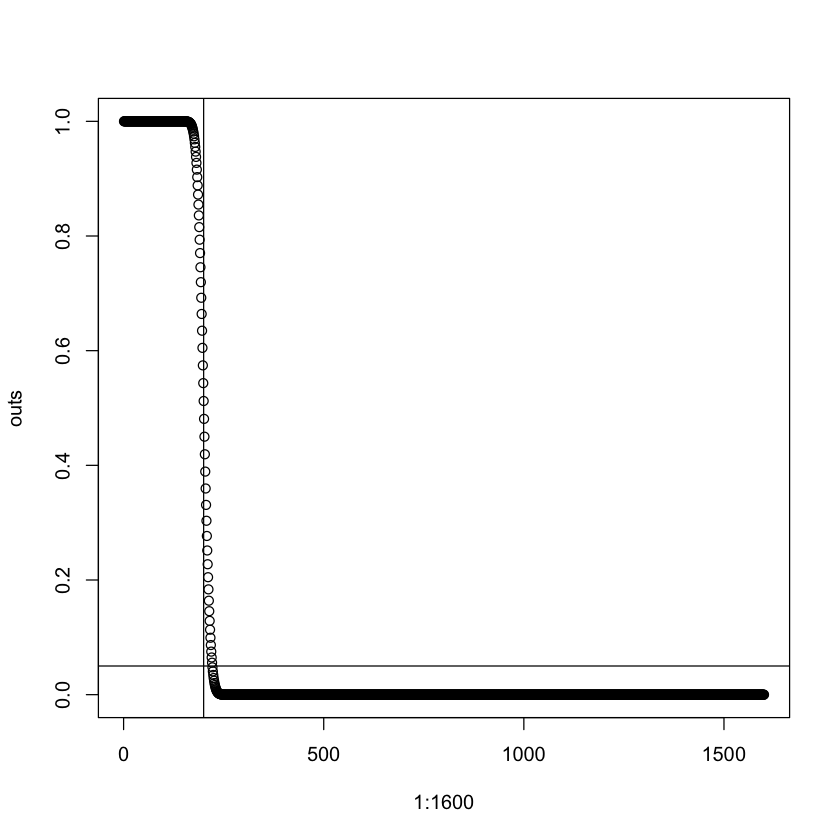

In [40]:
outs <- c()
for (i in 1:1600){
  outs <- c(outs, phyper(i-1, 1600, 24000-1600, 3000, lower.tail=FALSE))
}

plot(1:1600, outs)
abline(v=200, h=0.05)

[1] 200